In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
# Paths
data_dir_mfcc = r"C:\Users\Harshil\Documents\Codes\emotion-detection-multimodal\processed\mfcc"

# Transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Dataset
dataset = datasets.ImageFolder(root=data_dir_mfcc, transform=transform)


In [3]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

targets = np.array([s[1] for s in dataset.samples])
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_idx, val_idx in splitter.split(np.zeros(len(targets)), targets):
    train_ds = torch.utils.data.Subset(dataset, train_idx)
    val_ds = torch.utils.data.Subset(dataset, val_idx)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
train_size = len(train_loader.dataset)
val_size = len(val_loader.dataset)


In [4]:
#no of "neutral" samples in the training set are half as compared to the other classes
# so we will use weighted random sampler to balance the dataset

from sklearn.utils.class_weight import compute_class_weight
class_indices = [sample[1] for sample in dataset.samples]
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_indices), y=class_indices)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3,stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3,stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)

        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 8)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.fc(x)
        return x

In [6]:
# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Learning rate scheduler - monitor validation loss
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Early stopping setup
patience = 7
best_val_loss = float('inf')
epochs_without_improvement = 0
max_epochs = 100
model_loss = []

# Training loop
for epoch in range(1, max_epochs + 1):
    model.train()
    total_loss, total_correct = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (outputs.argmax(1) == labels).sum().item()

    train_acc = total_correct / train_size
    avg_train_loss = total_loss / len(train_loader)
    model_loss.append(avg_train_loss)

    print(f"\nEpoch [{epoch}/{max_epochs}]")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_acc:.4f}")

    # Validation
    model.eval()
    val_loss, val_correct = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_size

    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    # Scheduler step
    scheduler.step(avg_val_loss)

    # Log current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Learning Rate: {current_lr:.6f}")

    # Early stopping logic
    if avg_val_loss < best_val_loss - 1e-4:  # small delta to avoid noise
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        # Optional: torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_without_improvement += 1
        print(f"No improvement for {epochs_without_improvement} epoch(s)")

    if epochs_without_improvement >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch}")
        break



Epoch [1/100]
Train Loss: 2.5606, Train Accuracy: 0.1722
Validation Loss: 2.0819, Validation Accuracy: 0.1333
Learning Rate: 0.001000

Epoch [2/100]
Train Loss: 1.9749, Train Accuracy: 0.2343
Validation Loss: 1.9032, Validation Accuracy: 0.2806
Learning Rate: 0.001000

Epoch [3/100]
Train Loss: 1.9110, Train Accuracy: 0.2389
Validation Loss: 1.8882, Validation Accuracy: 0.2722
Learning Rate: 0.001000

Epoch [4/100]
Train Loss: 1.8540, Train Accuracy: 0.2611
Validation Loss: 1.7844, Validation Accuracy: 0.3028
Learning Rate: 0.001000

Epoch [5/100]
Train Loss: 1.8251, Train Accuracy: 0.2620
Validation Loss: 1.7443, Validation Accuracy: 0.3556
Learning Rate: 0.001000

Epoch [6/100]
Train Loss: 1.8343, Train Accuracy: 0.2417
Validation Loss: 1.7099, Validation Accuracy: 0.3778
Learning Rate: 0.001000

Epoch [7/100]
Train Loss: 1.7749, Train Accuracy: 0.2759
Validation Loss: 1.6646, Validation Accuracy: 0.3694
Learning Rate: 0.001000

Epoch [8/100]
Train Loss: 1.7249, Train Accuracy: 0.30

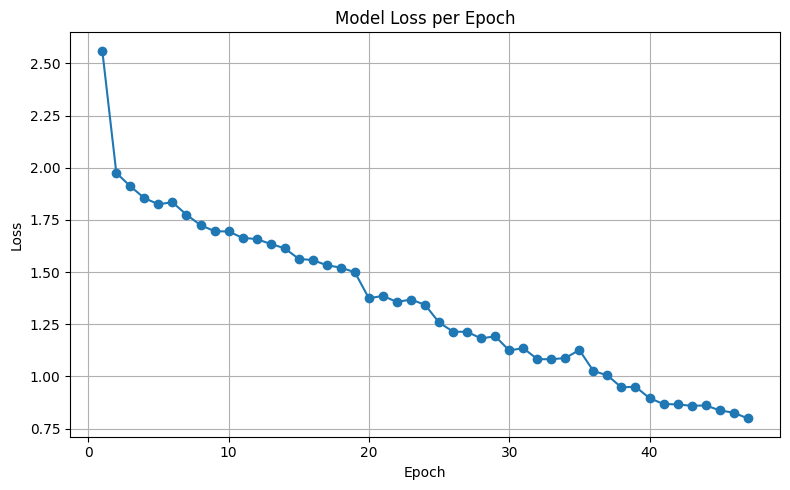

In [7]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(model_loss) + 1))
# Convert list of tensors to list of floats
# model_loss = [l.detach().item() if l.requires_grad else l.item() for l in model_loss]
# Plotting
plt.figure(figsize=(8, 5))
plt.plot(epochs, model_loss, marker='o')
plt.title('Model Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

Classification Report:
              precision    recall  f1-score   support

       angry       0.67      0.73      0.70        48
        calm       0.72      0.60      0.66        48
     disgust       0.81      0.60      0.69        48
     fearful       0.52      0.46      0.49        48
       happy       0.54      0.56      0.55        48
     neutral       0.33      0.21      0.26        24
         sad       0.36      0.58      0.44        48
   surprised       0.62      0.60      0.61        48

    accuracy                           0.57       360
   macro avg       0.57      0.54      0.55       360
weighted avg       0.59      0.57      0.57       360



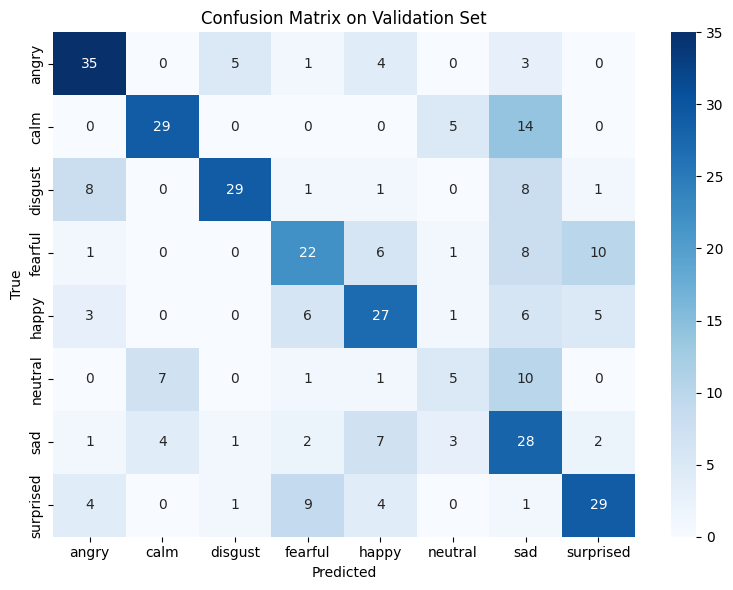

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Set model to evaluation mode
model.eval()

# Containers for true and predicted labels
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=dataset.classes))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Validation Set')
plt.tight_layout()
plt.show()


In [9]:
from torch.utils.data import Subset, WeightedRandomSampler
data_dir_mfcc = r"C:\Users\Harshil\Documents\Codes\emotion-detection-multimodal\processed\mfcc"

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

base_dataset = datasets.ImageFolder(root=data_dir_mfcc)

targets = np.array([s[1] for s in base_dataset.samples])
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_idx, val_idx in splitter.split(np.zeros(len(targets)), targets):
    pass  # unpacked train_idx and val_idx above

train_dataset = Subset(datasets.ImageFolder(root=data_dir_mfcc, transform=train_transform), train_idx)
val_dataset   = Subset(datasets.ImageFolder(root=data_dir_mfcc, transform=val_transform), val_idx)

train_targets = [targets[i] for i in train_idx]
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_targets), y=train_targets)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

class_sample_counts = np.bincount(train_targets)
weights = 1. / class_sample_counts
sample_weights = [weights[label] for label in train_targets]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)  # sampler overrides shuffle
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

train_size = len(train_loader.dataset)
val_size   = len(val_loader.dataset)

In [10]:
from torchvision.models import resnet18, ResNet18_Weights

# Load pretrained model
resnet = resnet18(weights=ResNet18_Weights.DEFAULT)

# Modify the final layer for 8 classes
resnet.fc = nn.Linear(resnet.fc.in_features, 8)
resnet = resnet.to(device)

# Define loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))
optimizer = optim.Adam(resnet.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Early stopping setup
patience = 7
best_val_loss = float('inf')
epochs_without_improvement = 0
max_epochs = 100

train_losses, val_losses = [], []

# Training loop
for epoch in range(1, max_epochs + 1):
    resnet.train()
    total_loss, total_correct = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (outputs.argmax(1) == labels).sum().item()

    avg_train_loss = total_loss / len(train_loader)
    train_acc = total_correct / train_size
    train_losses.append(avg_train_loss)

    print(f"\nEpoch [{epoch}/{max_epochs}]")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_acc:.4f}")

    # Validation
    resnet.eval()
    val_loss, val_correct = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == labels).sum().item()

            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_size
    val_losses.append(avg_val_loss)

    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    # Learning rate update
    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Learning Rate: {current_lr:.6f}")

    # Early stopping
    if avg_val_loss < best_val_loss - 1e-4:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_preds, best_labels = all_preds, all_labels  # Save best epoch predictions
        # torch.save(resnet.state_dict(), 'best_model.pth')
    else:
        epochs_without_improvement += 1
        print(f"No improvement for {epochs_without_improvement} epoch(s)")

    if epochs_without_improvement >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch}")
        break


Epoch [1/100]
Train Loss: 1.9726, Train Accuracy: 0.2444
Validation Loss: 2.8516, Validation Accuracy: 0.2194
Learning Rate: 0.001000

Epoch [2/100]
Train Loss: 1.7356, Train Accuracy: 0.3176
Validation Loss: 1.8708, Validation Accuracy: 0.3389
Learning Rate: 0.001000

Epoch [3/100]
Train Loss: 1.4906, Train Accuracy: 0.4083
Validation Loss: 1.9700, Validation Accuracy: 0.3139
Learning Rate: 0.001000
No improvement for 1 epoch(s)

Epoch [4/100]
Train Loss: 1.4964, Train Accuracy: 0.4259
Validation Loss: 2.0286, Validation Accuracy: 0.3417
Learning Rate: 0.001000
No improvement for 2 epoch(s)

Epoch [5/100]
Train Loss: 1.4580, Train Accuracy: 0.4213
Validation Loss: 2.0233, Validation Accuracy: 0.3694
Learning Rate: 0.001000
No improvement for 3 epoch(s)

Epoch [6/100]
Train Loss: 1.3406, Train Accuracy: 0.4880
Validation Loss: 2.8382, Validation Accuracy: 0.2556
Learning Rate: 0.000500
No improvement for 4 epoch(s)

Epoch [7/100]
Train Loss: 1.1733, Train Accuracy: 0.5463
Validation L

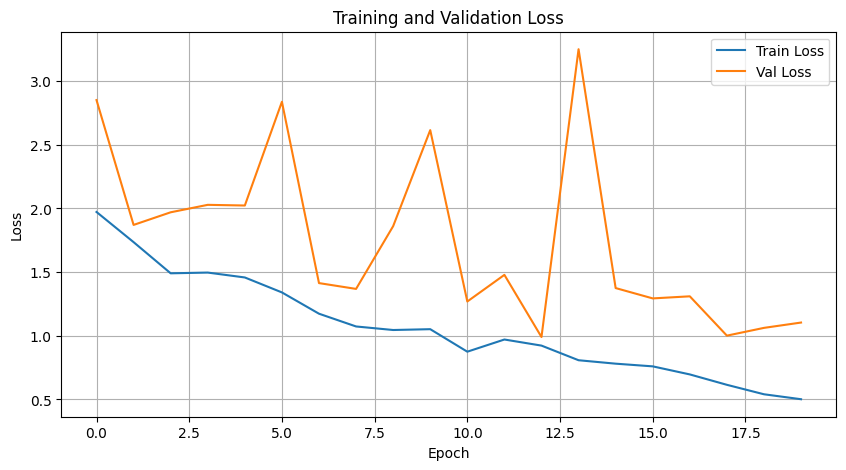

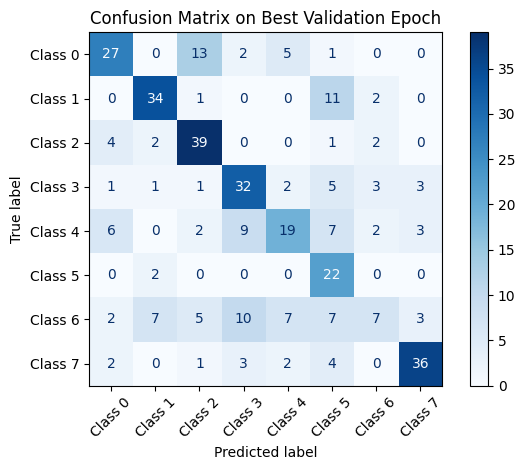

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# 📊 Confusion Matrix
cm = confusion_matrix(best_labels, best_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Class {i}" for i in range(8)])
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix on Best Validation Epoch")
plt.tight_layout()
plt.show()

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Final model stats
print("\nBest Model Validation Results:")
print(f"Best Validation Loss: {best_val_loss:.4f}")
print(f"Best Validation Accuracy: {val_acc:.2%}")  # Already computed

# Classification report
print("\nClassification Report:")
target_names = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
print(classification_report(best_labels, best_preds, target_names=target_names))



Best Model Validation Results:
Best Validation Loss: 0.9902
Best Validation Accuracy: 61.94%

Classification Report:
              precision    recall  f1-score   support

     neutral       0.64      0.56      0.60        48
        calm       0.74      0.71      0.72        48
       happy       0.63      0.81      0.71        48
         sad       0.57      0.67      0.62        48
       angry       0.54      0.40      0.46        48
     fearful       0.38      0.92      0.54        24
     disgust       0.44      0.15      0.22        48
   surprised       0.80      0.75      0.77        48

    accuracy                           0.60       360
   macro avg       0.59      0.62      0.58       360
weighted avg       0.61      0.60      0.58       360




Epoch [1/100]
Train Loss: 1.7652, Train Accuracy: 0.3037
Validation Loss: 1.6529, Validation Accuracy: 0.3639
Learning Rate: 0.001000

Epoch [2/100]
Train Loss: 1.4713, Train Accuracy: 0.4426
Validation Loss: 1.5816, Validation Accuracy: 0.3750
Learning Rate: 0.001000

Epoch [3/100]
Train Loss: 1.2249, Train Accuracy: 0.5278
Validation Loss: 1.2906, Validation Accuracy: 0.5389
Learning Rate: 0.001000

Epoch [4/100]
Train Loss: 1.0994, Train Accuracy: 0.5759
Validation Loss: 1.2007, Validation Accuracy: 0.5583
Learning Rate: 0.001000

Epoch [5/100]
Train Loss: 0.9684, Train Accuracy: 0.6333
Validation Loss: 1.2024, Validation Accuracy: 0.5861
Learning Rate: 0.001000
No improvement for 1 epoch(s)

Epoch [6/100]
Train Loss: 0.8548, Train Accuracy: 0.6713
Validation Loss: 1.2512, Validation Accuracy: 0.5778
Learning Rate: 0.001000
No improvement for 2 epoch(s)

Epoch [7/100]
Train Loss: 0.6787, Train Accuracy: 0.7528
Validation Loss: 1.2874, Validation Accuracy: 0.5722
Learning Rate: 0.00

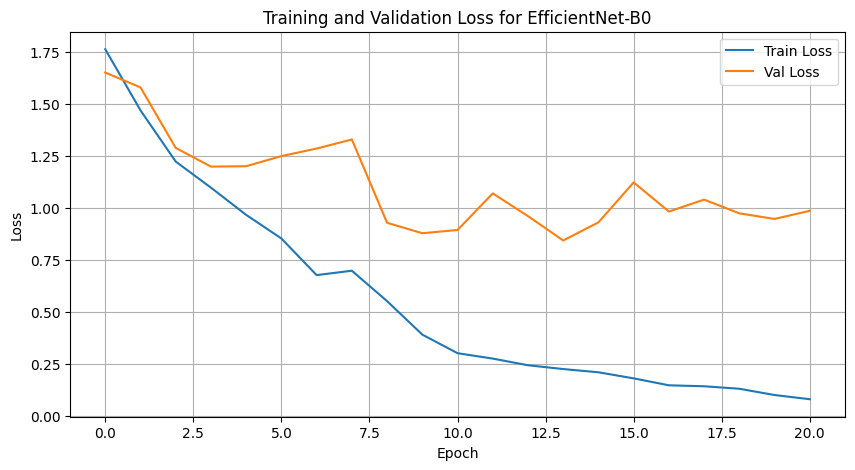


Best Model Validation Results:
Best Validation Loss: 0.8453
Best Validation Accuracy: 73.89%

Classification Report:
              precision    recall  f1-score   support

     neutral       0.80      0.75      0.77        48
        calm       0.73      0.83      0.78        48
       happy       0.79      0.71      0.75        48
         sad       0.67      0.79      0.72        48
       angry       0.74      0.67      0.70        48
     fearful       0.67      0.75      0.71        24
     disgust       0.54      0.42      0.47        48
   surprised       0.81      0.90      0.85        48

    accuracy                           0.72       360
   macro avg       0.72      0.73      0.72       360
weighted avg       0.72      0.72      0.72       360



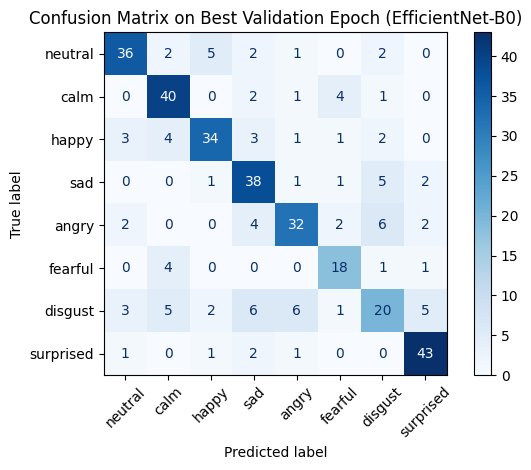

In [13]:
from torchvision.models import EfficientNet_B0_Weights, efficientnet_b0
# Load EfficientNet-B0 with pretrained weights

efnet = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
efnet.classifier[1] = nn.Linear(efnet.classifier[1].in_features, 8)  # Modify the final layer for 8 classes
efnet = efnet.to(device)
# Define loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))
optimizer = optim.Adam(efnet.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

#training steup

max_epochs = 100
patience = 7
best_val_loss = float('inf')
epochs_without_improvement = 0
train_losses, val_losses = [], []

for epoch in range(1,max_epochs+1):
    efnet.train()
    total_loss, total_correct = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = efnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (outputs.argmax(1) == labels).sum().item()

    avg_train_loss = total_loss / len(train_loader)
    train_acc = total_correct / train_size
    train_losses.append(avg_train_loss)

    print(f"\nEpoch [{epoch}/{max_epochs}]")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_acc:.4f}")

    # Validation
    efnet.eval()
    val_loss, val_correct = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = efnet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == labels).sum().item()

            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_size
    val_losses.append(avg_val_loss)

    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    # Learning rate update
    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Learning Rate: {current_lr:.6f}")

    # Early stopping
    if avg_val_loss < best_val_loss - 1e-4:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_preds, best_labels = all_preds, all_labels  # Save best epoch predictions
        # torch.save(resnet.state_dict(), 'best_model.pth')
    else:
        epochs_without_improvement += 1
        print(f"No improvement for {epochs_without_improvement} epoch(s)")

    if epochs_without_improvement >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch}")
        break
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss for EfficientNet-B0")
plt.legend()
plt.grid(True)
plt.show()
# Final model stats
print("\nBest Model Validation Results:")
print(f"Best Validation Loss: {best_val_loss:.4f}")
print(f"Best Validation Accuracy: {val_acc:.2%}")  # Already computed
# Classification report
print("\nClassification Report:")
target_names = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
print(classification_report(best_labels, best_preds, target_names=target_names))
# Confusion matrix
cm = confusion_matrix(best_labels, best_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix on Best Validation Epoch (EfficientNet-B0)")
plt.tight_layout()
plt.show()

torch.save(efnet.state_dict(), 'efficientnet_b0_best_model.pth')